In [1]:
%matplotlib inline

import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

In [2]:
df_data = pd.read_csv('C:/Users/okruz/Downloads/archive/data.csv')
df = df_data.copy()
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [3]:
df = df.rename(columns={'conversion': 'target'})
df = df.rename(columns={'offer': 'treatment'})
df.treatment = df.treatment.map({'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1})

In [4]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


<ipython-input-5-7d5da83599d0>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


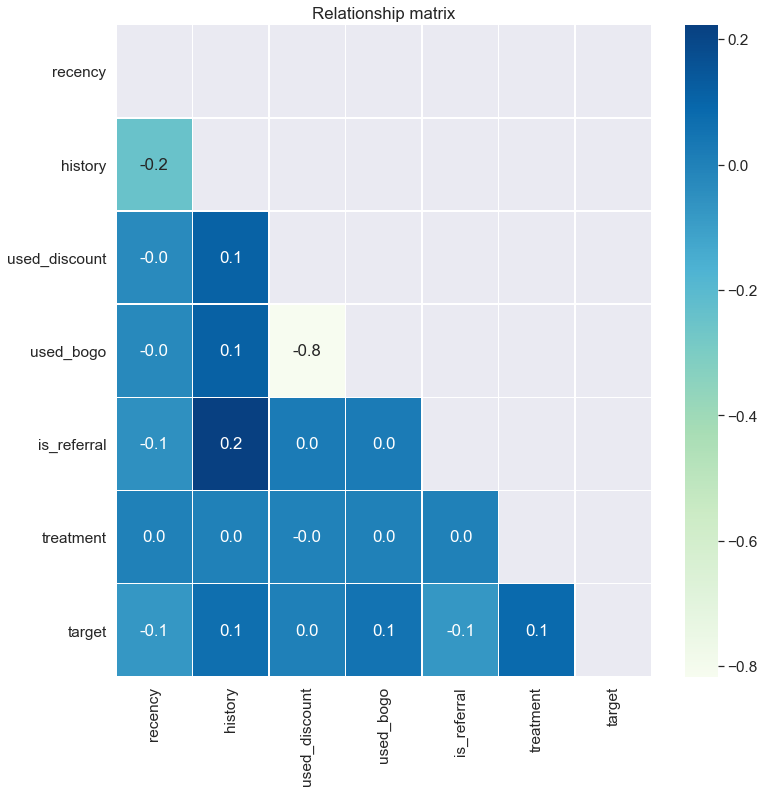

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

corr = df.corr()
plt.figure(figsize = (12, 12))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(df.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='GnBu')
plt.title('Relationship matrix')
plt.show()

In [6]:
target = 'target'

X = df.drop(columns=target)
y = df[target]

In [7]:
X['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [8]:
def zip_code_to_cat(X):
        
        X['zip_cat'] = np.nan
        
        X.loc[X['zip_code'] == 'Urban', 'zip_cat'] = 3
        X.loc[X['zip_code'] == 'Surburban', 'zip_cat'] = 2
        X.loc[X['zip_code'] == 'Rural', 'zip_cat'] = 1

            
        return X

In [9]:
X = zip_code_to_cat(X)
X.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,zip_cat
0,10,142.44,1,0,Surburban,0,Phone,1,2.0
1,6,329.08,1,1,Rural,1,Web,0,1.0
2,7,180.65,0,1,Surburban,1,Web,1,2.0
3,9,675.83,1,0,Rural,1,Web,1,1.0
4,2,45.34,1,0,Urban,0,Web,1,3.0


In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [11]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier

In [12]:
treatment = 'treatment'

treat_train = X_train[treatment]
X_train = X_train.drop(columns=treatment)

treat_val = X_valid[treatment]
X_valid = X_valid.drop(columns=treatment)

# X_train_full = df_features.loc[indices_train, :]
# y_train_full = df_train.loc[:, 'target']
# treat_train_full = df_train.loc[:, 'treatment_flg']

# X_test = df_features.loc[indices_test, :]

cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@20%': []
}

uplift@10%: 0.1042


array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

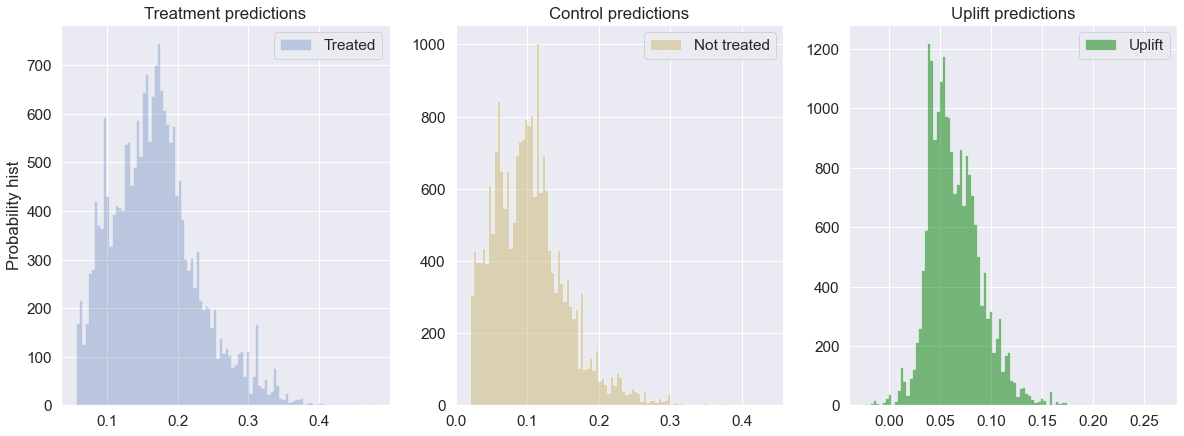

In [13]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_valid)

sm_score = uplift_at_k(y_true=y_valid, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

In [14]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,20.486225
1,is_referral,20.041619
2,recency,12.703239
3,history,10.160382
4,channel,9.807152
5,used_bogo,9.314088
6,zip_cat,8.759064
7,used_discount,7.692008
8,zip_code,1.036223


In [15]:
models_results

{'approach': ['SoloModel'], 'uplift@10%': [0.10422242318330505]}

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

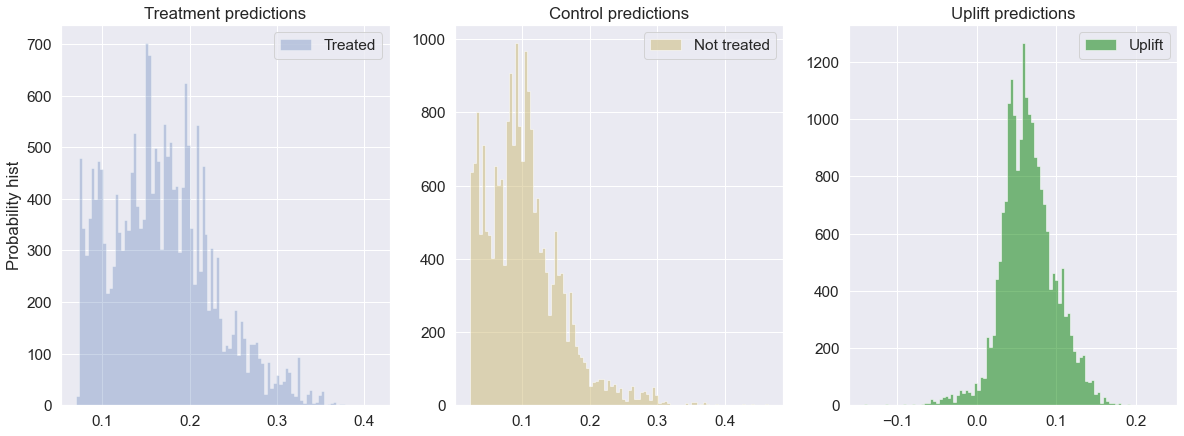

In [16]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_valid)

tm_score = uplift_at_k(y_true=y_valid, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

In [17]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%
0,SoloModel,0.104222
1,TwoModels,0.090868


In [18]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_valid)

ct_score = uplift_at_k(y_true=y_valid, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score)

<ipython-input-18-4e1879950542>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


In [19]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%
0,SoloModel,0.104222
1,TwoModels,0.090868
2,ClassTransformation,0.074786


In [20]:
models_results20 = {
    'approach': [],
    'uplift@20%': []
}

uplift@20%: 0.0753


array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

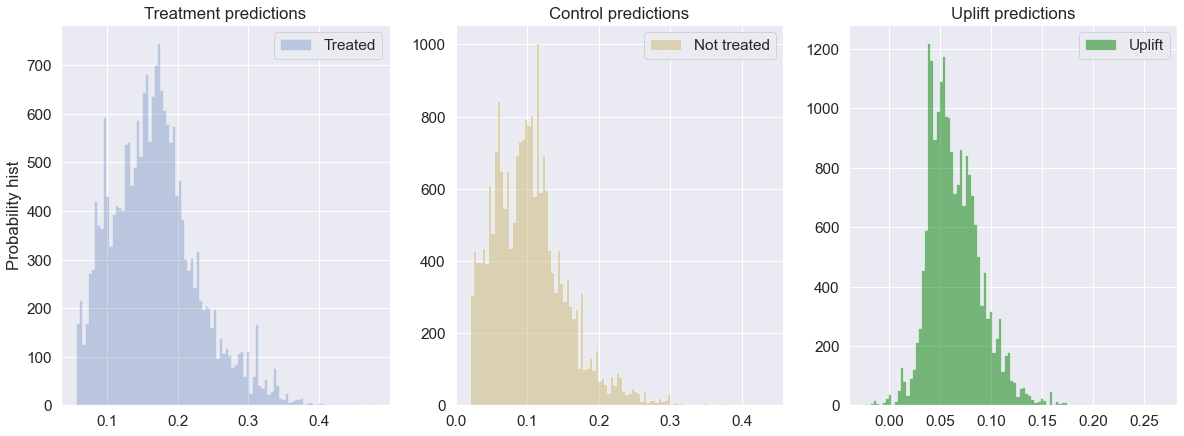

In [21]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_valid)

sm_score = uplift_at_k(y_true=y_valid, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score:.4f}')

models_results20['approach'].append('SoloModel')
models_results20['uplift@20%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

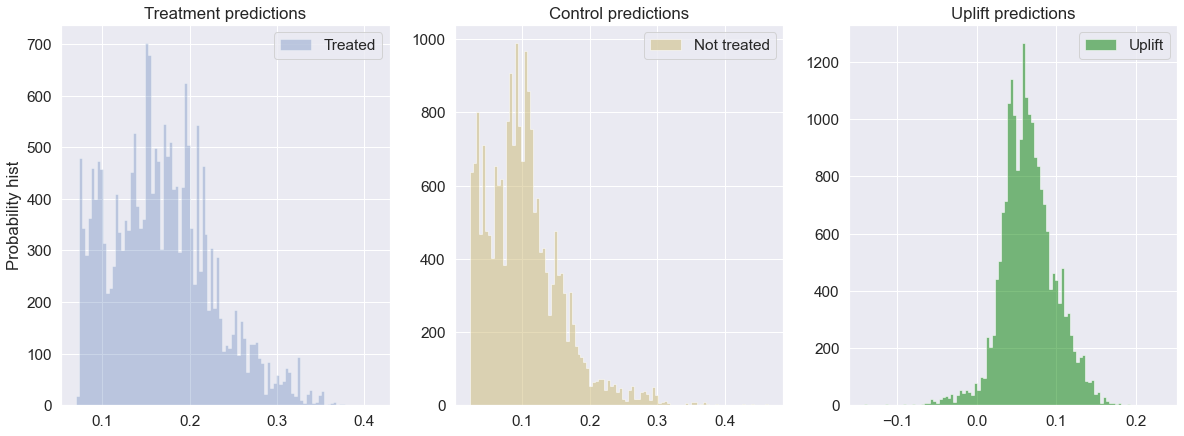

In [22]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_valid)

tm_score = uplift_at_k(y_true=y_valid, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results20['approach'].append('TwoModels')
models_results20['uplift@20%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

In [23]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_valid)

ct_score = uplift_at_k(y_true=y_valid, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

models_results20['approach'].append('ClassTransformation')
models_results20['uplift@20%'].append(ct_score)

<ipython-input-23-c17c040a5e62>:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


In [24]:
pd.DataFrame(data=models_results20).sort_values('uplift@20%', ascending=False)

,approach,uplift@20%
1,TwoModels,0.075432
0,SoloModel,0.075305
2,ClassTransformation,0.068170
